## CS6700 PA3 - Options

`Authors: Aditya C (CS20B003), Kruthic Vignesh (CS20B045)`

### Imports and Config

In [30]:
import numpy as np
from tqdm import tqdm
import random

import gymnasium as gym

import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
""" Learning parameters """

GAMMA = 0.9
ALPHA = 0.5

""" Locations of marked states in the Taxi-v3 environment """

env = gym.make("Taxi-v3")
RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC = map(
    lambda x: x[0] * 5 + x[1], env.unwrapped.locs
)
MID_LOC = 10

# location_dict = {0: RED_LOC, 1: GREEN_LOC, 2: YELLOW_LOC, 3: BLUE_LOC}
location_dict = {0: MID_LOC}
env.close()

""" Constants for the Taxi-v3 environment """
GRID_SIZE = 25
N_PRIMITIVE_MOVES = 4
N_PRIMITIVE_ACTIONS = N_PRIMITIVE_MOVES + 2
N_OPTIONS = 1
N_TOTAL_ACTIONS = N_PRIMITIVE_ACTIONS + N_OPTIONS

### Action Selection: $\epsilon$-greedy policy

In [32]:
def epsilonGreedyPolicy(q_value_arr, epsilon=0.1):
    if random.random() < epsilon:
        return random.randint(0, len(q_value_arr) - 1)
    else:
        return np.argmax(q_value_arr)

### Options Framework

In [33]:
class Option:

    def __init__(
        self,
        num_positions: int,
        num_actions: int,
        terminal_position: int,
        gamma: float = GAMMA,
        alpha: float = ALPHA,
    ):
        self.q_value = np.zeros((num_positions, num_actions))
        self.terminal_position = terminal_position
        self.gamma = gamma
        self.alpha = alpha

    def reset(self):
        self.q_value = np.zeros_like(self.q_value)

    def state_to_position(self, state: int):
        return state // 20

    def get_action(self, state: int, epsilon: float = 0.1):
        """
        - state: int, the current state (0 - 499)
        - epsilon: float, the probability of selecting a random action
        """
        # The state is converted to a position in the grid since the option is agnostic to the destination and passenger locations.
        position = self.state_to_position(state)
        return epsilonGreedyPolicy(self.q_value[position], epsilon)

    def q_update(
        self, state: int, action: int, reward: float, next_state: int, done: bool
    ):
        """Update the Q-value of the option using the Q-learning update rule."""
        position = self.state_to_position(state)
        next_position = self.state_to_position(next_state)
        self.q_value[position, action] += self.alpha * (
            reward
            + self.gamma * np.max(self.q_value[next_position]) * (not done)
            - self.q_value[position, action]
        )

    def check_done(self, state: int):
        """The option terminates if the agent reaches terminal position."""
        return self.state_to_position(state) == self.terminal_position

### Hierarchical Reinforcement Learning

- In HRL, we look at the problem as a hierarchy of tasks. 

- The high-level policy selects a subgoal, and the low-level policy tries to achieve that subgoal. 

- The high-level policy is trained using the options framework & Q-learning, and the low-level policy is trained using the Q-learning algorithm.

In [34]:
class HRL_Agent:

    def __init__(
        self,
        state_size: int,
        action_size: int,
        primitive_dir_flag: bool,
        gamma: float,
        alpha: float,
    ):
        self.q_values = np.zeros((state_size, action_size))
        self.update_freq = np.zeros((state_size, action_size))
        self.gamma = gamma
        self.alpha = alpha
        self.primitive_dir_flag = primitive_dir_flag
        self.offset = 0 if self.primitive_dir_flag == True else 4
        self.options = []
        for i, loc in enumerate([MID_LOC]):
            self.options.append(Option(25, 4, loc))
        self.set_terminal_blocks()
    
    def set_terminal_blocks(self):
        """ Disallow option invocation in the terminal states """
        for i, loc in enumerate([MID_LOC]):
            for j in range(20):
                self.q_values[loc * 20 + j, 6 + i] = -1e9   
                # setting to -np,inf causes some computational warnings later, so setting to -1e9

    def reset(self):
        """Reset all bookkeeping variables."""
        self.q_values = np.zeros_like(self.q_values)
        self.update_freq = np.zeros_like(self.update_freq)
        for option in self.options:
            option.reset()
        self.set_terminal_blocks()


    def update_primitive(self, state: int, action: int, reward: float, next_state: int, done: bool):
        """Update the Q-value of the primitive action using the Q-learning update rule."""
        self.q_values[state, action] += self.alpha * (
            reward
            + self.gamma * np.max(self.q_values[next_state][self.offset:]) * (not done)
            - self.q_values[state, action]
        )
        self.update_freq[state, action] += 1

In [35]:
class SMDP_Agent(HRL_Agent):

    def __init__(
        self, state_size, action_size, primitive_dir_flag, gamma=GAMMA, alpha=ALPHA
    ):
        super().__init__(state_size, action_size, primitive_dir_flag, gamma, alpha)

    def update_option_midway(self, *args, **kwargs):
        """There is no midway update for SMDP agents."""
        return

    def update_option_once(
        self,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        opt_duration: int,
        done: bool,
    ):
        """At the end of the option, update Q(option_start_state, option)"""
        self.q_values[state, action] += self.alpha * (
            reward
            + (self.gamma**opt_duration)
            * np.max(self.q_values[next_state][self.offset :])
            * (not done)
            - self.q_values[state, action]
        )
        self.update_freq[state, action] += 1

In [36]:
class IOQL_Agent(HRL_Agent):

    def __init__(self, state_size, action_size, primitive_dir_flag, gamma=GAMMA, alpha=ALPHA):
        super().__init__(state_size, action_size, primitive_dir_flag, gamma, alpha)

    def update_option_midway(
        self,
        option: int,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        opt_done: bool,
        done: bool,
    ):
        # Update primitive action's Q-value for current state
        self.update_primitive(state, action, reward, next_state, done)

        # Update option's Q-value for current state
        next_val = (
            opt_done * np.max(self.q_values[next_state][self.offset :])
            + (1 - opt_done) * self.q_values[next_state, option]
        )
        self.q_values[state, option] += self.alpha * (
            reward + self.gamma * next_val * (not done) - self.q_values[state, option]
        )
        self.update_freq[state, option] += 1

    def update_option_once(self, *args, **kwargs):
        """There is no end-of-option update for IOQL agents."""
        return

In [37]:
class Trainer:
    """ Brings together the environment and the agent to train the agent."""

    def __init__(self, env: gym.Env, agent: HRL_Agent):
        self.env = env
        self.agent = agent
        self.scores_arr, self.steps_arr = [], []
        self.mean_scores_arr, self.mean_steps_arr = [], []
    
    def reset(self):
        self.agent.reset()
        self.scores_arr, self.steps_arr = [], []
        
    def train(self, num_episodes: int = 1):
        """ Train the agent for a fixed number of episodes."""
        
        self.scores_arr, self.steps_arr = [], []
        epsilon = 0.1
        dropoff_0_count = 0
        dropoff_0_bad = 0
        dropoff_0_good = 0

        for episode in tqdm(range(num_episodes)):

            state, _ = self.env.reset()
            done = False
            total_reward, total_steps = 0, 0
            action_list = []

            epsilon = max(0.01, epsilon * 0.9975)

            # while episode is not over
            while not done:

                """ Choose action: epsilon-greedy policy """
                action = epsilonGreedyPolicy(self.agent.q_values[state][self.agent.offset:], epsilon) + self.agent.offset
                action_list.append(action)

                """ Primitive actions - South, North, East, West, Pickup, Dropoff """
                if action < 6:
                    next_state, reward, is_terminal, is_trunc, _ = self.env.step(action)
                    total_steps += 1
                    done = is_terminal or is_trunc
                    total_reward += reward
                    self.agent.update_primitive(state, action, reward, next_state, done)
                    state = next_state

                else:
                    """ Options - Go to Red, Green, Yellow, Blue """
                    opt_start_state, opt_id = state, action - 6
                    opt_reward, opt_duration = 0, 0
                    opt_done = self.agent.options[opt_id].check_done(state)

                    """ If invoking option from terminal state, set q-values to -1e9 """
                    if opt_done:
                        self.agent.q_values[state, action] = -1e9
                        continue
                        
                    """ Execute option """
                    while not opt_done and not done:

                        # choose action
                        opt_action = self.agent.options[opt_id].get_action(state, epsilon=epsilon)

                        # take action
                        next_state, reward, is_terminal, is_trunc, _ = self.env.step(opt_action)
                        total_steps += 1
                        done = is_terminal or is_trunc
                        total_reward += reward
                        opt_reward += reward * (self.agent.gamma**opt_duration)

                        # update option's q-values
                        self.agent.options[opt_id].q_update(state, opt_action, reward, next_state, done)
                        
                        # update q-values of agent
                        opt_done = self.agent.options[opt_id].check_done(next_state)
                        self.agent.update_option_midway(
                                action, state, opt_action, reward, next_state, opt_done, done
                        )

                        # update variables
                        opt_duration += 1
                        state = next_state

                    """ End of option - update q-values """
                    # for SMDP Q-Learning
                    self.agent.update_option_once(
                        opt_start_state, action, opt_reward, next_state, opt_duration, done
                    )

                """ If episode is over, append total reward """
                if done:
                    self.scores_arr.append(total_reward)
                    self.steps_arr.append(total_steps)
    
        return self.scores_arr, self.steps_arr

    def train_multiple_runs(self, num_runs: int = 1, num_episodes: int = 1):
        """ Train the agent for a fixed number of runs, each consisting of a fixed number of episodes."""
        
        self.mean_scores_arr, self.mean_steps_arr = [], []
        for run in tqdm(range(num_runs)):
            self.reset()
            scores, steps = self.train(num_episodes)
            self.mean_scores_arr.append(scores)
            self.mean_steps_arr.append(steps)

        self.mean_scores_arr = np.array(self.mean_scores_arr)
        self.mean_steps_arr = np.array(self.mean_steps_arr)


    def plot_scores(self, window_size: int = 5):
        """ Plot score array of the agent """
        
        # aggregate every 5 elements for smoother plot        
        raw_scores_arr = self.mean_scores_arr.mean(axis=0)
        scores_arr = raw_scores_arr[: len(raw_scores_arr) // window_size * window_size].reshape(
            -1, window_size
        )
        scores_arr = scores_arr.mean(axis=1)

        plt.figure(figsize=(10, 5))
        x_vals = np.arange(window_size, len(scores_arr) * window_size + window_size, window_size)
        plt.plot(x_vals, scores_arr)
        
        raw_std_arr = np.std(self.mean_scores_arr, axis=0)
        std_arr = raw_std_arr[: len(raw_std_arr) // window_size * window_size].reshape(
            -1, window_size
        )
        std_arr = std_arr.mean(axis=1)
        plt.fill_between(x_vals, scores_arr - std_arr, scores_arr + std_arr, alpha=0.2)
        
        
        max_score = np.max(self.mean_scores_arr)
        min_score = np.min(self.mean_scores_arr)
        mean_score = round(np.mean(self.mean_scores_arr), 2)

        plt.hlines(max_score, 0, window_size * len(scores_arr), colors="g", linestyles="--")
        plt.hlines(mean_score, 0, window_size * len(scores_arr), colors="b", linestyles="--")

        # annotate the max, min and mean scores
        plt.annotate(f"Max: {max_score}", (0, max_score-15), color="g")
        plt.annotate(f"Mean: {mean_score}", (window_size * len(scores_arr) - 150, mean_score-15), color="b")
        
        plt.xlabel("Episode number")
        plt.ylabel("Total reward")
        plt.title("(Undiscounted) Episodic reward over time")
        
        print(f"Max score: {max_score}, Min score: {min_score}, Mean score: {mean_score}")
        print("Mean over last 200 episodes: ", np.mean(raw_scores_arr[-200:]))

        plt.show()

    def plot_steps(self, window_size: int = 5):
        """ Plot steps array of the agent """

        # aggregate every 5 elements for smoother plot
        raw_steps_arr = np.mean(self.mean_steps_arr, axis=0)
        steps_arr = raw_steps_arr[: len(raw_steps_arr) // window_size * window_size].reshape(
            -1, window_size
        )
        steps_arr = steps_arr.mean(axis=1)

        plt.figure(figsize=(10, 5))
        x_vals = np.arange(window_size, len(steps_arr) * window_size + window_size, window_size)
        plt.plot(x_vals, steps_arr)
        
        raw_std_arr = np.std(self.mean_steps_arr, axis=0)
        std_arr = raw_std_arr[: len(raw_std_arr) // window_size * window_size].reshape(
            -1, window_size
        )
        std_arr = std_arr.mean(axis=1)
        plt.fill_between(x_vals, steps_arr - std_arr, steps_arr + std_arr, alpha=0.2)

        max_steps = np.max(self.mean_steps_arr)
        min_steps = np.min(self.mean_steps_arr)
        mean_steps = round(np.mean(self.mean_steps_arr), 2)

        plt.hlines(min_steps, 0, window_size * len(steps_arr), colors="g", linestyles="--")
        plt.hlines(mean_steps, 0, window_size * len(steps_arr), colors="b", linestyles="--")

        # annotate the max, min and mean steps
        plt.annotate(f"Min: {min_steps}", (0, min_steps+5), color="g")
        plt.annotate(f"Mean: {mean_steps}", (window_size * len(steps_arr) - 150, mean_steps+5), color="b")
        
        plt.xlabel("Episode number")
        plt.ylabel("Total steps")
        plt.title("Episodic steps over time")
        
        print(f"Max steps: {max_steps}, Min steps: {min_steps}, Mean steps: {mean_steps}")
        print("Mean over last 200 episodes: ", np.mean(raw_steps_arr[-200:]))

        plt.show()

In [38]:
N_TOTAL_ACTIONS

7

In [39]:
# agent = SMDP_Agent(500, N_TOTAL_ACTIONS, True)
agent = IOQL_Agent(500, N_TOTAL_ACTIONS, True)
trainer = Trainer(env, agent)
trainer.train_multiple_runs(5, 1000)

100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Max score: 15, Min score: -587, Mean score: -27.46
Mean over last 200 episodes:  7.059000000000001


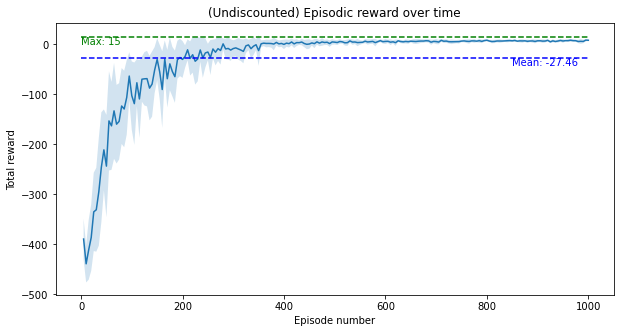

Max steps: 200, Min steps: 6, Mean steps: 34.89
Mean over last 200 episodes:  13.662000000000003


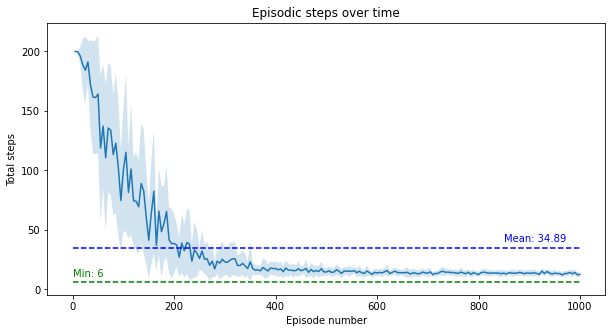

In [40]:
trainer.plot_scores()
trainer.plot_steps()

# Max score: 15, Min score: -434, Mean score: -53.87
# Mean over last 200 episodes:  -18.477999999999998


# Max steps: 200, Min steps: 6, Mean steps: 49.63
# Mean over last 200 episodes:  28.336000000000002

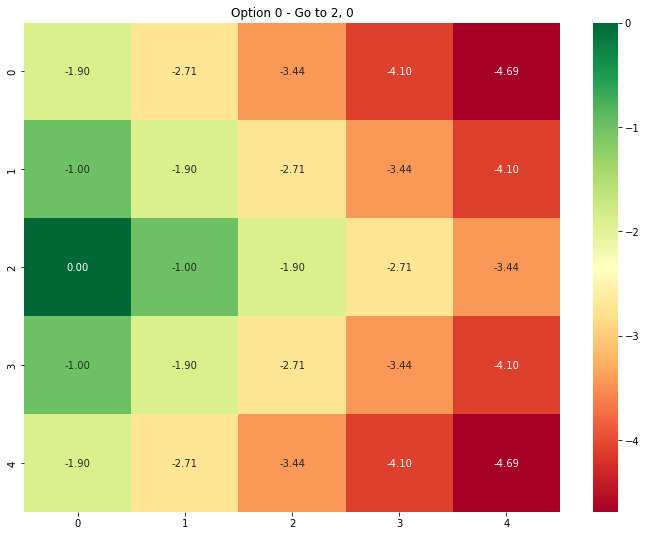

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
grid = np.zeros((4, 5, 5))

i = 0
grid[i] = np.max(agent.options[i].q_value, axis=1).reshape(5, 5)
sns.heatmap(grid[i], ax=ax, annot=True, fmt=".2f", cmap="RdYlGn")
ax.set_title(
    f"Option {i} - Go to {['2, 0'][i]}"
)

plt.show()

In [42]:
dict = {
    0: "↓",
    1: "↑",
    2: "→",
    3: "←",
    4: "Pickup",
    5: "Dropoff",
    6: "R",
    7: "G",
    8: "Y",
    9: "B",
}

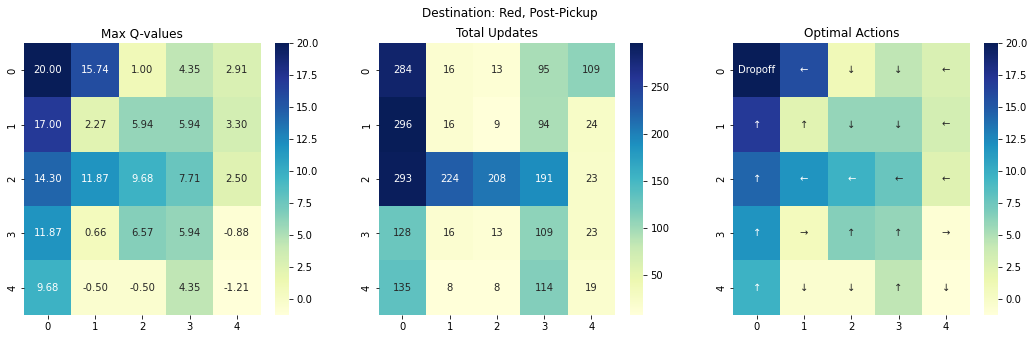

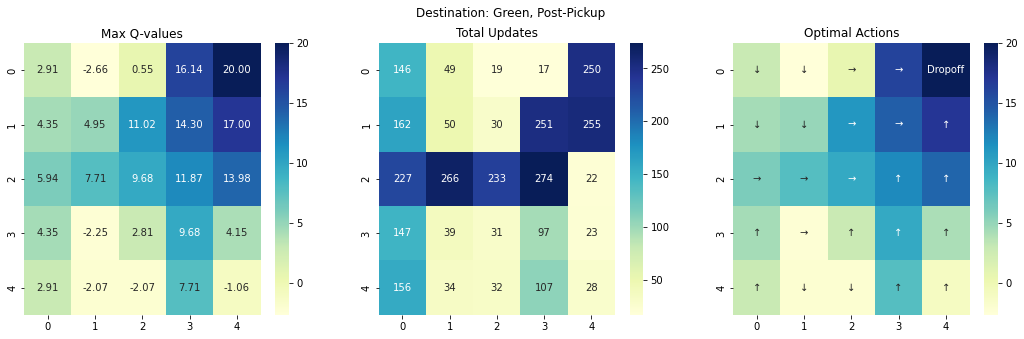

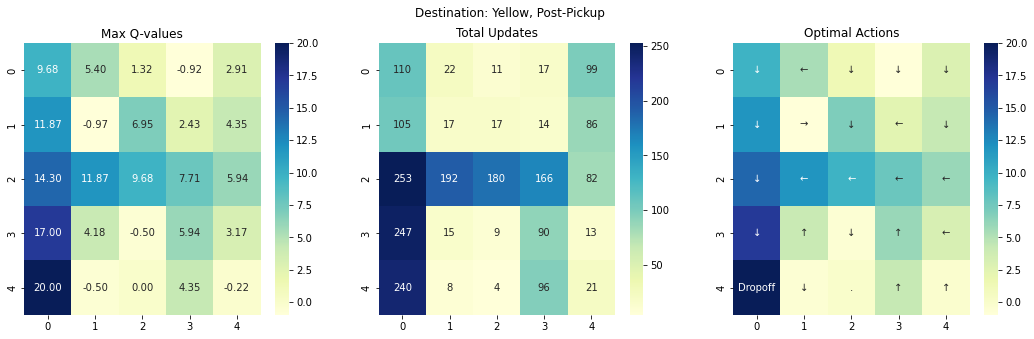

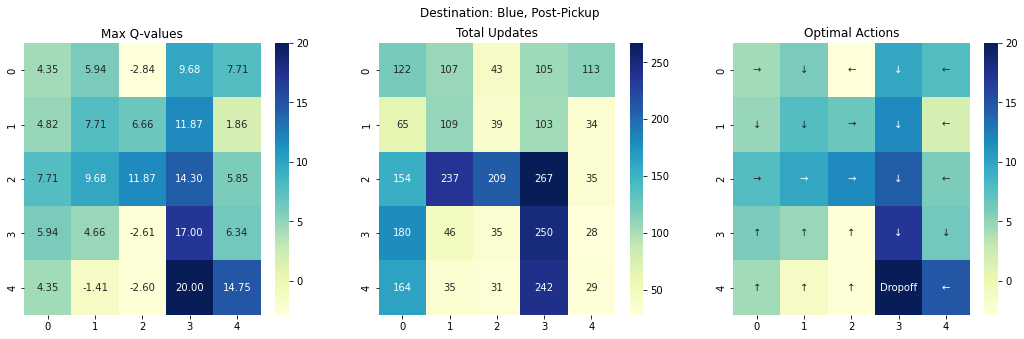

In [43]:
# select every 4th row of q_values and put it into a grid

opt_start = 0

# desination fixed to be red
for dest in range(4):

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    fig.suptitle(f"Destination: {['Red', 'Green', 'Yellow', 'Blue'][dest]}, Post-Pickup")
    
    q_grid = trainer.agent.q_values[dest::4]
    upd_grid = trainer.agent.update_freq[dest::4]

    # passenger is inside car
    q_grid = q_grid[4::5]
    upd_grid = upd_grid[4::5]

    # grid = grid[:, 6].reshape(5, 5)
    q_val_grid = np.max(q_grid[:, opt_start:], axis=1).reshape(5, 5)

    upd_sum_grid = np.sum(upd_grid[:,opt_start:], axis=1).reshape(5, 5)

    q_ind_grid = np.argmax(q_grid[:,opt_start:], axis=1) + opt_start
    q_dir_grid = np.vectorize(dict.get)(q_ind_grid).reshape(5, 5)
    
    # Max Q-values heatmap
    ax[0].set_title("Max Q-values")
    sns.heatmap(q_val_grid, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax[0])

    # Total updates heatmap
    ax[1].set_title("Total Updates")
    upd_sum_grid = upd_sum_grid.astype(int)
    sns.heatmap(upd_sum_grid, annot=True, fmt="d", cmap="YlGnBu", ax=ax[1])

    for i in range(5):
        for j in range(5):
            if upd_sum_grid[i][j] <= 1 or q_val_grid[i][j] == 0:
                q_dir_grid[i][j] = "."

    # print grid2 with row and column labels, I dont want heatmap of grid2
    ax[2].set_title("Optimal Actions")
    sns.heatmap(q_val_grid, annot=q_dir_grid, fmt="s", cmap="YlGnBu", ax=ax[2])
    plt.show()

In [44]:
dest = 0
pass_loc = 1
initpos = 0

st = (initpos * 5 + pass_loc) * 4 + dest
print([round(i, 2) for i in trainer.agent.q_values[st]] )
# print([int(i) for i in trainer.agent.update_freq[st]])

[-5.22, -5.43, -5.47, -5.6, -10.88, -9.75, -5.52]


In [45]:
dest = 0
pass_loc = 1
initpos = 5

st = (initpos * 5 + pass_loc) * 4 + dest
print([round(i, 2) for i in trainer.agent.q_values[st]] )
# print([int(i) for i in trainer.agent.update_freq[st]])

[-5.5, -5.33, -4.46, -5.37, -9.75, -9.75, -5.5]


In [46]:
dest = 0
pass_loc = 1
initpos = 10

st = (initpos * 5 + pass_loc) * 4 + dest
print([round(i, 2) for i in trainer.agent.q_values[st]] )
# print([int(i) for i in trainer.agent.update_freq[st]])

[-5.33, -5.32, -3.84, -5.32, -11.04, -12.53, -1000000000.0]


In [47]:
dest = 0
pass_loc = 1
initpos = 15

st = (initpos * 5 + pass_loc) * 4 + dest
print([round(i, 2) for i in trainer.agent.q_values[st]] )
# print([int(i) for i in trainer.agent.update_freq[st]])

[-5.26, -5.05, -5.12, -5.07, -7.84, -9.75, -5.05]


In [48]:
dest = 0
pass_loc = 1
initpos = 20

st = (initpos * 5 + pass_loc) * 4 + dest
print([round(i, 2) for i in trainer.agent.q_values[st]] )
# print([int(i) for i in trainer.agent.update_freq[st]])

[-5.34, -5.46, -5.49, -5.37, -8.69, -9.75, -5.58]


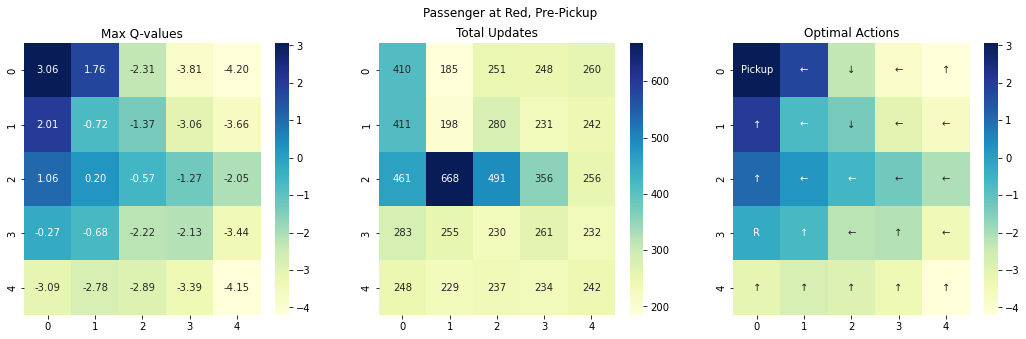

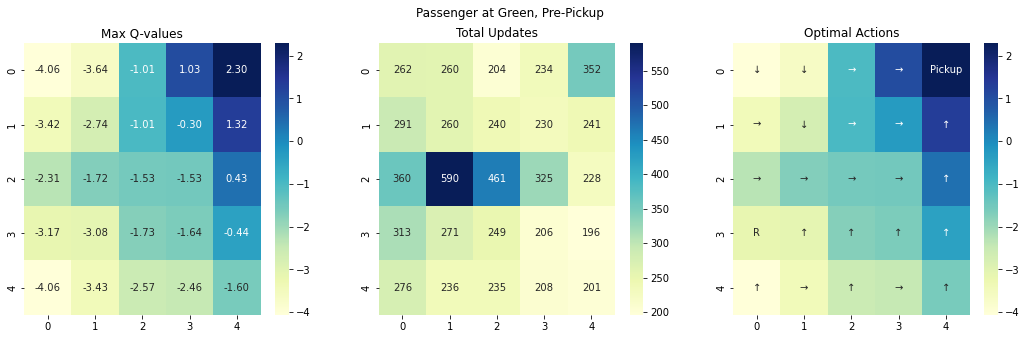

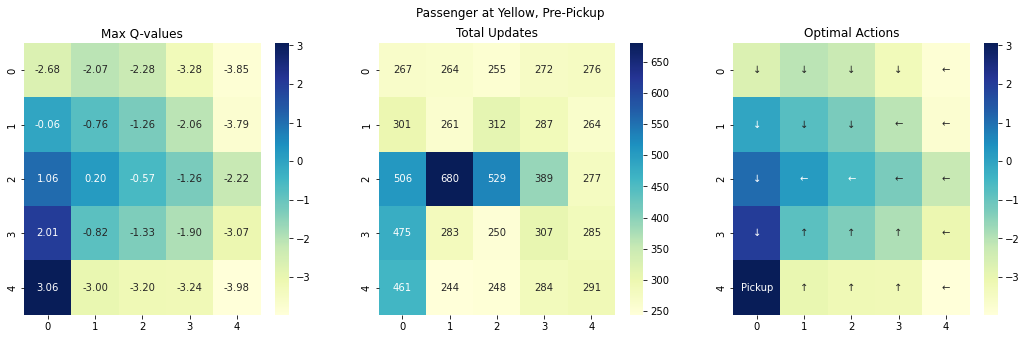

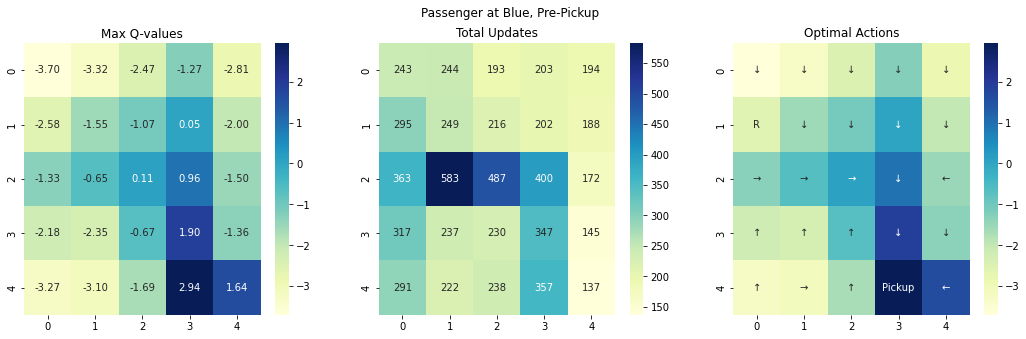

In [49]:
opt_start = 0

for dest in range(4):

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    fig.suptitle(f"Passenger at {['Red', 'Green', 'Yellow', 'Blue'][dest]}, Pre-Pickup")
    
    q_grid = trainer.agent.q_values.reshape(-1, 4, N_TOTAL_ACTIONS).mean(axis=1)[dest::5]
    upd_grid = trainer.agent.update_freq.reshape(-1, 4, N_TOTAL_ACTIONS).sum(axis=1)[dest::5]

    # passenger is inside car
    # q_grid = q_grid[dest::5]
    # upd_grid = upd_grid[dest::5]

    # grid = grid[:, 6].reshape(5, 5)
    q_val_grid = np.max(q_grid[:, opt_start:], axis=1).reshape(5, 5)

    upd_sum_grid = np.sum(upd_grid[:,opt_start:], axis=1).reshape(5, 5)

    q_ind_grid = np.argmax(q_grid[:,opt_start:], axis=1) + opt_start
    q_dir_grid = np.vectorize(dict.get)(q_ind_grid).reshape(5, 5)
    
    # Max Q-values heatmap
    ax[0].set_title("Max Q-values")
    sns.heatmap(q_val_grid, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax[0])

    # Total updates heatmap
    ax[1].set_title("Total Updates")
    upd_sum_grid = upd_sum_grid.astype(int)
    sns.heatmap(upd_sum_grid, annot=True, fmt="d", cmap="YlGnBu", ax=ax[1])

    for i in range(5):
        for j in range(5):
            if upd_sum_grid[i][j] <= 1:
                q_dir_grid[i][j] = "."

    # print grid2 with row and column labels, I dont want heatmap of grid2
    ax[2].set_title("Optimal Actions")
    sns.heatmap(q_val_grid, annot=q_dir_grid, fmt="s", cmap="YlGnBu", ax=ax[2])
    plt.show()

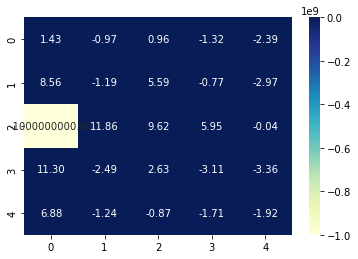

[['Dropoff' '←' '↓' '↓' '←']
 ['↑' '↑' '↓' '↓' '←']
 ['↑' '←' '←' '←' '←']
 ['↑' '→' '↑' '↑' '→']
 ['↑' '↓' '↓' '↑' '↓']]


In [50]:
# select every 4th row of q_values and put it into a grid

# desination fixed to be red
grid = trainer.agent.q_values[::4]
grid2 = trainer.agent.q_values[::4]

# passenger is inside car
grid = grid[4::5]
grid2 = grid2[4::5]

grid = grid[:, 6].reshape(5, 5)
grid2 = np.argmax(grid2, axis=1)

grid2 = [dict[i] for i in grid2]
grid2 = np.array(list(grid2)).reshape(5, 5)
# plot the grid
sns.heatmap(grid, annot=True, fmt=".2f", cmap="YlGnBu")
plt.show()

# print grid2 with row and column labels, I dont want heatmap of grid2
print(grid2)

In [51]:
st = (4 * 5 + 4) * 4 + 0
print([round(i, 2) for i in trainer.agent.q_values[st]] )
print([int(i) for i in trainer.agent.update_freq[st]])

[-0.14, -1.65, -1.85, 2.91, -9.49, -2.11, -2.39]
[8, 4, 4, 82, 3, 3, 5]


In [52]:
st = (0 * 5 + 4) * 4 + 0
trainer.agent.q_values[st]

array([10.48125  ,  8.25     ,  8.3425293, 12.5546875,  6.375    ,
       20.       ,  1.426875 ])